# 2.2: Two-Body Potential Energy Surface

Next, we will parameterize the "physical baseline" ($V_{phys}$) of the PEF.

In this section, we construct, from scratch, a 1-body MB-nrg-style PEF for CH3-NH2.

## 2.1.0 Definitions and Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

In [2]:
%run Tutorial_2_Imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%run Tutorial_2_Paths.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## II.1.? Normal Modes Configuration Generation

In [4]:
definition_CH3NH2 = read_definition(paths.definitions.systems.CH3NH2)
minimized_structure_CH3NH2, minimized_energy_CH3NH2 = read_system_and_energy(definition_CH3NH2, paths.structures.minimized_CH3NH2)

definition_H2O = read_definition(paths.definitions.systems.H2O)
minimized_structure_H2O, minimized_energy_H2O = read_system_and_energy(definition_H2O, paths.structures.minimized_H2O)

definition_CH3NH2_H2O = read_definition(paths.definitions.systems.CH3NH2_H2O)

In [5]:
clusters_CH3NH2_H2O = read_systems(definition_CH3NH2_H2O, paths.clusters.CH3NH2_H2O)
vibrational_modes_clusters_CH3NH2_H2O = read_multiple_vibrational_modes(paths.clusters.CH3NH2_H2O_modes)

In [6]:
configurations_vibrational_modes_CH3NH2_H2O = []

for cluster, modes in zip(clusters_CH3NH2_H2O, vibrational_modes_clusters_CH3NH2_H2O):
    configuration_generator = NormalModesConfigurationGenerator(
            cluster,
            modes,
            distribution="linear",
            temperature=(10, 150)
    )

    configs = list(configuration_generator.generate_configurations(num_configs=300, seed=54321))
    configurations_vibrational_modes_CH3NH2_H2O.extend(configs)
    
write_systems(paths.PIP_CH3NH2_H2O.configs.vibrational_modes, configurations_vibrational_modes_CH3NH2_H2O)

Will generate configurations over a linear temperature distribution from 10 K to 150 K.
Temp Distribution: temp (au) = 0.0004433562 * x + 3.1668299999999996e-05 for x in range [0,1].
Beginning normal modes configuration generation.
Will generate 300 configs over the temperature distribution.
Generating Temperature Distribution Configs...
Normal Distribution Configuration generation complete! Generated 300 configs.
Will generate configurations over a linear temperature distribution from 10 K to 150 K.
Temp Distribution: temp (au) = 0.0004433562 * x + 3.1668299999999996e-05 for x in range [0,1].
Beginning normal modes configuration generation.
Will generate 300 configs over the temperature distribution.
Generating Temperature Distribution Configs...
Normal Distribution Configuration generation complete! Generated 300 configs.
Single negative frequency detected in input. This most likely means the given geometry is a transition state.
Will generate configurations over a linear temperature

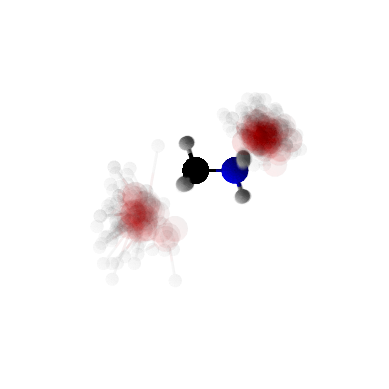

In [7]:
render_overlayed_systems(
    configurations_vibrational_modes_CH3NH2_H2O,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[4].point, system.atoms[3].point),
    alpha=0.03,
    num_to_show=100
)

Let's generate the second set of configurations for our training set, those from metadynamics configurations.

## II.1.? Parallel-Bias Metadynamics Configuration Generation

In [7]:
vibrational_modes_CH3NH2_H2O = read_multiple_vibrational_modes(paths.clusters.CH3NH2_H2O_modes)[0]

In [8]:
bond_params, angle_params, nonbonded_params = get_pbmetad_parameters(
        clusters_CH3NH2_H2O[0]
)

In [9]:
bond_params

{('A', 'B'): (60, 1.0899486044930917),
 ('A', 'C'): (100, 1.4870216225214954),
 ('C', 'D'): (60, 1.0327059940972794),
 ('E', 'F'): (60, 0.9893584176464172)}

In [10]:
angle_params

{('B', 'A', 'C'): (15, 110.49967007185985),
 ('D', 'C', 'D'): (15, 104.64302138506169),
 ('B', 'A', 'B'): (15, 108.41073323121982),
 ('A', 'C', 'D'): (15, 107.6893579030835),
 ('F', 'E', 'F'): (15, 100.26000827451064)}

In [11]:
nonbonded_params

{'A': (0.03, 1.8),
 'B': (0.01, 0.9),
 'C': (0.03, 1.8),
 'D': (0.01, 0.9),
 'E': (0.03, 1.8),
 'F': (0.01, 0.9)}

In [12]:
charges = read_parameters(paths.Vphys.charges)
charges = {symmetry: charges[symmetry]*1/3 for symmetry in charges}
charges["E"] = -0.6*1/3
charges["F"] = +0.3*1/3

In [13]:
# paths.restart.pbmetad_CH3NH2_H2O.remove()
# paths.scratch.pbmetad_CH3NH2_H2O.remove()

In [14]:
perform_pbmetad_simulation(
        lammps_executable_path,
        [minimized_structure_CH3NH2, minimized_structure_H2O],
        num_configs=500000,
        sample_interval=10,
        temperature=700,
        seed=12345,
        configurations_path=paths.PIP_CH3NH2_H2O.configs.pbmetad_pool,
        bond_params=bond_params,
        angle_params=angle_params,
        nonbonded_params=nonbonded_params,
        charges=charges,
        pbmetad_workdir=paths.scratch.pbmetad_CH3NH2_H2O,
        restart_path=paths.restart.pbmetad_CH3NH2_H2O,
        min_intermolecular_distance=1.5,
        max_intermolecular_distance=9.0
)

PBMetaD already completed. Will not rerun!


In [15]:
inner_cutoff_2b = 5.0
outer_cutoff_2b = 6.0

In [16]:
num_filtered_configs = filter_configs_by_cutoff(
        definition_CH3NH2_H2O,
        paths.PIP_CH3NH2_H2O.configs.pbmetad_pool,
        threshold=outer_cutoff_2b,
        filtered_path=paths.PIP_CH3NH2_H2O.configs.pbmetad_pool_filtered
)

Found 295825 within cutoff distance of 6.0


In [17]:
split_pool(
        definition_CH3NH2_H2O,
        paths.PIP_CH3NH2_H2O.configs.pbmetad_pool_filtered,
        pool_size=num_filtered_configs,
        num_configs_to_split=200,
        unsplit_path=paths.PIP_CH3NH2_H2O.configs.pbmetad_train_pool,
        split_path=paths.PIP_CH3NH2_H2O.configs.pbmetad_test,
        strategy="INTERVAL",
)

In [18]:
# paths.restart.fps_CH3NH2_H2O.remove()
# paths.scratch.fps_CH3NH2_H2O.remove()

In [19]:
pbmetad_configs_CH3NH2_H2O = perform_fps(
        definition_CH3NH2_H2O,
        clusters_CH3NH2_H2O[0],
        vibrational_modes_clusters_CH3NH2_H2O[0],
        paths.PIP_CH3NH2_H2O.configs.pbmetad_train_pool,
        num_pool_configs=num_filtered_configs-200,
        num_phase1_input_configs=100000,
        approx_configs_to_select=1000,
        fps_workdir=paths.scratch.fps_CH3NH2_H2O,
        restart_path=paths.restart.fps_CH3NH2_H2O,
        num_threads=16
)

Phase1 already complete. Will not rerun.
Phase2 already complete. Will not rerun.
Selected 1206 total configs by FPS.


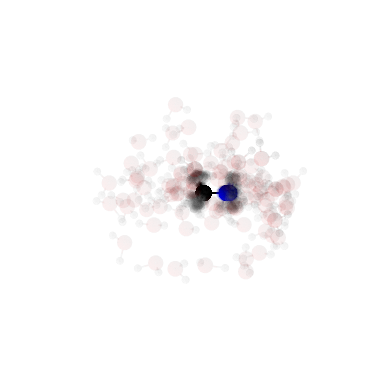

In [25]:
render_overlayed_systems(
    pbmetad_configs_CH3NH2_H2O,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[4].point, system.atoms[3].point),
    alpha=0.03,
    num_to_show=100
)

In [26]:
write_systems(paths.PIP_CH3NH2_H2O.configs.pbmetad_train, pbmetad_configs_CH3NH2_H2O)

## II.1.? Energy Calculation

Next, we need to perform the electronic structure calculations with our chosen reference level of theory. We will use CCSD(T). Because this can be quite expensive and this tutorial is menat to be something that can be finished in a few hours, we have precomputed the energies for you. So we will just copy them over:

In [20]:
calculator = Psi4Calculator("HF", "STO-3G", paths.logs, )

In [21]:
# paths.restart.energies_vibrational_mode_configs_CH3NH2_H2O.remove()
# paths.restart.energies_pbmetad_configs_CH3NH2_H2O.remove()

In [ ]:
energies_vibrational_modes_CH3NH2_H2O = calculate_nmer_energies(
        configurations_vibrational_modes_CH3NH2_H2O,
        calculator,
        get_qchem_job_manager(paths.jobs),
        paths.restart.energies_vibrational_mode_configs_CH3NH2_H2O,
        num_threads=4,
        mem_mb=8000,
        error_on_any_failure=False
)
write_systems_and_nmer_energies(paths.PIP_CH3NH2_H2O.configs.vibrational_modes_energies, (configurations_vibrational_modes_CH3NH2_H2O, energies_vibrational_modes_CH3NH2_H2O))

Energy calculation for n-mer (1,) in system 536 failed!==========================                                         | - 1609/2700
Running energy calculations |===========================================================                                         | - 1609/2700
Energy calculation for n-mer (0, 1) in system 536 failed!
Running energy calculations |===========================================================                                         | - 1609/2700


PSIO_ERROR: Attempt to write into next entry: 64, HF DIIS vector: target Entry 0, Item 0 Symmetry 0 Irrep 0
PSIO_ERROR: unit = 64, errval = 18


Energy calculation for n-mer (0,) in system 537 failed!
Running energy calculations |===========================================================                                         | - 1609/2700


In [ ]:
energies_pbmetad_CH3NH2_H2O = calculate_nmer_energies(
        pbmetad_configs_CH3NH2_H2O,
        calculator,
        get_qchem_job_manager(paths.jobs),
        paths.restart.energies_pbmetad_configs_CH3NH2_H2O,
        num_threads=4,
        mem_mb=8000
)
write_systems_and_nmer_energies(paths.PIP_CH3NH2_H2O.configs.pbmetad_train_energies, (pbmetad_configs_CH3NH2_H2O, energies_pbmetad_CH3NH2_H2O))

In [41]:
energies_2b_vibrational_modes_CH3NH2_H2O = calculate_many_body_energies(
    configurations_vibrational_modes_CH3NH2_H2O,
    energies_vibrational_modes_CH3NH2_H2O,
    minimized_monomer_energies=[minimized_energy_CH3NH2, minimized_energy_H2O]
)

energies_2b_pbmetad_CH3NH2_H2O = calculate_many_body_energies(
    pbmetad_configs_CH3NH2_H2O,
    energies_pbmetad_CH3NH2_H2O,
    minimized_monomer_energies=[minimized_energy_CH3NH2, minimized_energy_H2O]
)

In [42]:
write_training_set_file(
        paths.PIP_CH3NH2_H2O.training_set,
        (
                [*configurations_vibrational_modes_CH3NH2_H2O, *pbmetad_configs_CH3NH2_H2O],
                [*energies_1b_vibrational_modes_CH3NH2_H2O, *energies_1b_pbmetad_CH3NH2_H2O],
                [*energies_1b_vibrational_modes_CH3NH2_H2O, *energies_1b_pbmetad_CH3NH2_H2O],
        )
)

In [43]:
min(energies_1b_vibrational_modes_CH3NH2), max(energies_1b_vibrational_modes_CH3NH2_H2O)

(0.07426190999831306, 148.74226191000344)

In [44]:
min(energies_1b_pbmetad_CH3NH2), max(energies_1b_pbmetad_CH3NH2_H2O)

(46.52726190999965, 537.3892619100006)